In [1]:
import os
os.chdir("../src")
print(os.getcwd())

import copy
import numpy as np
import math
import operator
import matplotlib.pyplot as plt

from poc.run_agent import run_agent, plot_expts

%matplotlib inline
%load_ext autoreload
%autoreload 2

/scratch/cluster/clw4542/dshape/src


In [11]:
results_dir = "/scratch/cluster/clw4542/gridworld_results2/"
# world_default_max_ts = [5000, 15000, 30000]
world_default_max_ts = [2e6, 5e6, 1e7]
# world_dependent_params = {
#                           10: {"n_episodes": 5000}, 
#                           20: {"n_episodes": 15000}, 
#                           30: {"n_episodes": 30000
#                           }}
world_dependent_params = {
                          10: {"total_train_ts": 2e6}, 
                          20: {"total_train_ts": 5e6}, 
                          30: {"total_train_ts": 1e7
                          }}

# eval_freq = 50 
eval_interval = 20000


In [12]:
def compile_logs(results_dir, expt_name, n_trials):
    env_rets = []
    for trial_idx in range(n_trials):
        load_path = os.path.join(results_dir, expt_name, f"trial={trial_idx}", "logs.npz")
        res = np.load(load_path, allow_pickle=True)
        env_ret_trial = res["env_ret"] # learning curve for single trial
        if env_ret_trial.shape[0] == 500:
            print(load_path)
        env_rets.append(env_ret_trial)
        
    env_rets = np.array(env_rets)
    means = np.mean(env_rets, axis=0)
    stds = np.std(env_rets, axis=0)
    opt_rew = res["opt_rew"]
    return opt_rew, means, stds, res["eval_ts"]

In [15]:
def plot_learning_curves(expt_basenames:dict, world_sizes:list, results_dir:str, 
                         world_max_ts:list=world_default_max_ts,
                         title="",
                         save=False,
                         savedir="../workshop_figures/",
                         savename=None
                        ):
    fig, axes = plt.subplots(1,len(world_sizes), 
                             figsize=(4*len(world_sizes),3), 
                            )

    for i, world_size in enumerate(world_sizes):
        max_ts = int(world_max_ts[i])
        for expt_label, expt_basename in expt_basenames.items():
            opt_rew, exp_means, exp_stds, eval_ts = compile_logs(results_dir, 
                                                        expt_name=f"{expt_basename}_world=basic_size={world_size}",
                                                        n_trials=30)
            exp_means = exp_means[:max_ts]
            exp_stds = exp_stds[:max_ts]

            axes[i].plot(eval_ts, exp_means, label=expt_label)
            axes[i].fill_between(eval_ts, exp_means-exp_stds, exp_means+exp_stds,
                            alpha=0.5 #, edgecolor=color, facecolor=color 
                            )
        axes[i].axhline(opt_rew, 
                        label="Optimal return", 
                        linestyle="--")
        axes[i].set_xlim(0, max_ts)
        axes[i].set_title(f"World Size {world_size}")
        
    fig.suptitle(title, y=1.1)
    fig.text(0.5, -0.05, 'Timesteps', ha='center', fontsize=14)
    fig.text(0.05, 0.5, 'Returns', va='center', rotation='vertical', fontsize=14)

    axes[-1].legend(loc=(1.1, 0))
    if save:
        if not os.path.exists(savedir):
            os.mkdir(savedir)            
        savepath = os.path.join(savedir, savename + ".pdf")
        
        print(f"Saving to {savepath}")
        plt.savefig(savepath, bbox_inches="tight")

    plt.show()

### Core Figure

Saving to ../workshop_figures/gridworld_core_result.pdf


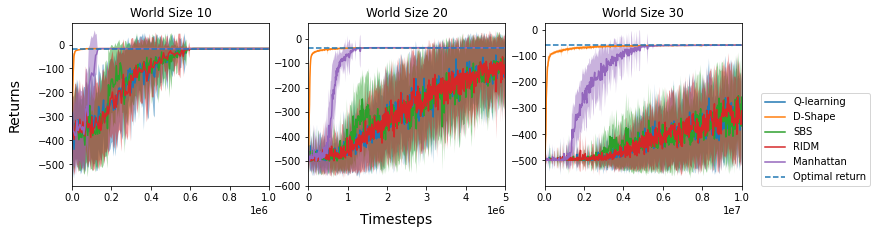

In [17]:
# TODO: how to plot curve so that the std dev shading isn't above 0?
plot_learning_curves(expt_basenames={
                     "Q-learning": "q-learning", 
                     "D-Shape": "dshape", 
                     "SBS": "sbs", 
                     "RIDM": "ridm-state-aug-alone", 
                     "Manhattan": "manhattan"
}, 
                     title="",
                     world_sizes=[10, 20, 30], 
                     results_dir=results_dir, 
#                      world_max_ts=[3500, 15000, 30000],
#                      eval_freq=eval_freq,
                     world_max_ts=[1e6, 5e6, 1e7],
                     save=True,
                     savename="gridworld_core_result"
                     )

### Ablation Expt

Saving to ../workshop_figures/ablation_with_ridm.pdf


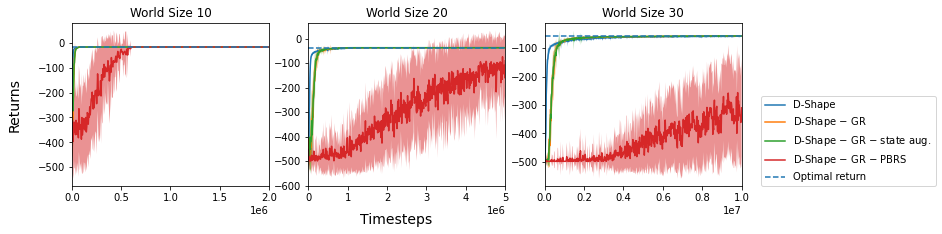

In [21]:
plot_learning_curves(expt_basenames={
     "D-Shape": "dshape", 
     r"D-Shape $-$ GR":"pbrs+state-aug",
     r"D-Shape $-$ GR $-$ state aug.": "pbrs_alone", 
    r"D-Shape $-$ GR $-$ PBRS": "ridm-state-aug-alone", 
}, 
                     title="", # "Ablation Experiment"
                     world_sizes=[10, 20, 30], 
                     results_dir=results_dir, 
#                      world_max_ts=[1e5, 1e6, 1e6],
                     save=True,
#                      savename="ablation"
                     savename="ablation_with_ridm"
                    )

### Suboptimal Demonstrations (wrong goal, all world sizes)

In [22]:
def plot_subopt_learning_curves_all(expt_basenames:dict, results_dir:str, 
                                    world_sizes:list, 
                                    world_max_ts:list=world_default_max_ts,
                                    title="",
                                    save=False,
                                    savename=None,
                                    savedir="../workshop_figures/",
                        ):
    fig, axes = plt.subplots(1,len(world_sizes), 
                             figsize=(4*len(world_sizes),3), 
                            )

    for i, world_size in enumerate(world_sizes):
        max_ts = int(world_max_ts[i])
        for expt_label, expt_basename in expt_basenames[world_size].items():
            opt_rew, exp_means, exp_stds, eval_ts = compile_logs(results_dir, 
                                                        expt_name=f"{expt_basename}_world=basic_size={world_size}",
                                                        n_trials=30)
            exp_means = exp_means[:max_ts]
            exp_stds = exp_stds[:max_ts]

            axes[i].plot(eval_ts, exp_means, label=expt_label)
            axes[i].fill_between(eval_ts, exp_means-exp_stds, exp_means+exp_stds,
                            alpha=0.5 #, edgecolor=color, facecolor=color 
                            )
        axes[i].axhline(opt_rew, 
                        label="Optimal return", 
                        linestyle="--")
        axes[i].set_xlim(0, max_ts)
        axes[i].set_title(f"World Size {world_size}")
        
    fig.suptitle(title, y=1.1)
    fig.text(0.5, -0.05, 'Timesteps', ha='center', fontsize=14)
    fig.text(0.05, 0.5, 'Returns', va='center', rotation='vertical', fontsize=14)

    axes[-1].legend(loc=(1.1, 0))
    if save:
        if not os.path.exists(savedir):
            os.mkdir(savedir)            
        savepath = os.path.join(savedir, savename + ".pdf")
        
        print(f"Saving to {savepath}")
        plt.savefig(savepath, bbox_inches="tight")

    plt.show()

In [28]:
subopt_demo_dict = {
            10: {"good": 7, "medium": 5, "worst": 3},
            20: {"good": 17, "medium": 15, "worst": 13},
            30: {"good": 25, "medium": 21, "worst": 17}
}

expt_names = ["D-Shape", "Manhattan"] # formatted names
expt_basenames = {}

for world_size, subopt_opts in subopt_demo_dict.items():
    expt_basenames[world_size] = {}
    for expt_display_name in expt_names:
        expt_name = expt_display_name.lower().replace("-", "")
        expt_basenames[world_size][f"{expt_display_name}, optimal"] = expt_name
        for opt_name, opt_goal in subopt_opts.items():
            expt_basenames[world_size][f"{expt_display_name}, {opt_name}"] = f"{expt_name}_demo-goal={opt_goal}"

Saving to ../workshop_figures/suboptimal_demos_world-size=all.pdf


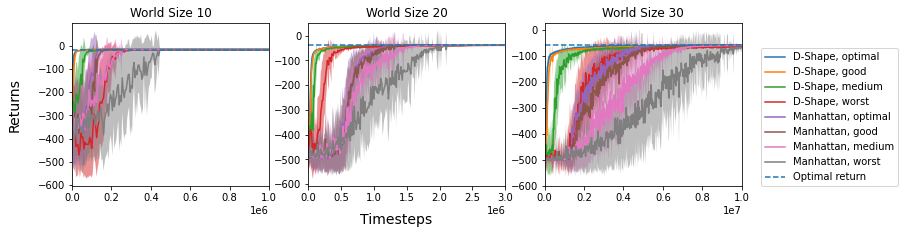

In [29]:
plot_subopt_learning_curves_all(expt_basenames=expt_basenames, 
                     world_sizes=[10, 20, 30],
                     results_dir=results_dir, 
#                      world_max_ts=world_default_max_ts,
                     world_max_ts=[1e6, 3e6, 1e7],
#                      title="Robustness to Suboptimal Demonstrations",
#                      legend_loc=(11, 0),
                     save=True,
                     savename="suboptimal_demos_world-size=all",
                     savedir="../workshop_figures/"
                    )

## Suboptimal Demonstrations (Single Plots)

In [30]:
def plot_subopt_learning_curves(expt_basenames:dict, results_dir:str, world_size:int,
                                title="",
                                world_max_ts:int=5e6,
                                legend_loc=(1.1, 0.5),
                                save=False,
                                savename=None,
                                savedir="../workshop_figures/",
                        ):
    fig, axes = plt.subplots(1,1, 
                             figsize=(4,3), 
                            )

    max_ts = int(world_max_ts)
    for expt_label, expt_basename in expt_basenames.items():
        opt_rew, exp_means, exp_stds, eval_ts = compile_logs(results_dir, 
                                                    expt_name=f"{expt_basename}_world=basic_size={world_size}",
                                                    n_trials=30)
        exp_means = exp_means[:max_ts]
        exp_stds = exp_stds[:max_ts]

        axes.plot(eval_ts, exp_means, label=expt_label)
        axes.fill_between(eval_ts, exp_means-exp_stds, exp_means+exp_stds,
                        alpha=0.5 #, edgecolor=color, facecolor=color 
                        )

    axes.axhline(opt_rew, 
                    label="Optimal return", 
                    linestyle="--")
    axes.set_xlim(0, max_ts)
        
    fig.suptitle(title, y=1.0)
    fig.text(0.5, -0.05, 'Timesteps', ha='center')
    fig.text(-0.05, 0.5, 'Returns', va='center', rotation='vertical')

    axes.legend(loc=legend_loc)
    
    if save:
        if not os.path.exists(savedir):
            os.mkdir(savedir)            
        savepath = os.path.join(savedir, savename + ".pdf")
        print(f"Saving to {savepath}")
        plt.savefig(savepath, bbox_inches="tight")

    plt.show()

Saving to ../workshop_figures/suboptimal_demos_coef.pdf


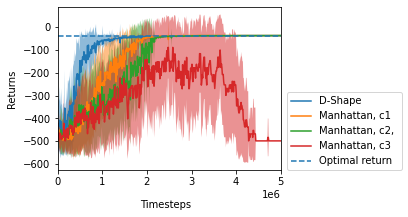

In [31]:
plot_subopt_learning_curves(expt_basenames={
#      "D-Shape, optimal demo": "dshape_termphi0=False",
     "D-Shape": "dshape_termphi0=False_demo-goal=13", 
#      "D-Shape, subopt demo, c2": "dshape_termphi0=False_demo-goal=13_rew-coef=20", 
#      "D-Shape, subopt demo, c3": "dshape_termphi0=False_demo-goal=13_rew-coef=25", 
    
#      "Manhattan, optimal demo": "manhattan_termphi0=False",
     "Manhattan, c1": "manhattan_termphi0=False_demo-goal=13", 
#      "Manhattan_demo-goal=13_rew-coef=5", 
#      "Manhattan_demo-goal=13_rew-coef=10", 
#      "Manhattan_demo-goal=13_rew-coef=15", 
     "Manhattan, c2, ": "manhattan_termphi0=False_demo-goal=13_rew-coef=20", 
     "Manhattan, c3": "manhattan_termphi0=False_demo-goal=13_rew-coef=25", 
}, 
                     world_size=20,
                     results_dir=results_dir, 
                     world_max_ts=5e6, # 3e6
#                      title="Robustness to Hyperparameters",
                     legend_loc=(1.03, 0),
                     save=True,
                     savename="suboptimal_demos_coef",
                     savedir="../workshop_figures/"
                    )

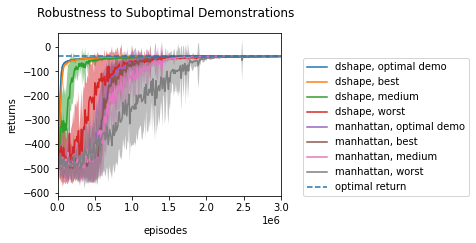

In [8]:
plot_subopt_learning_curves(expt_basenames={ # legend name: expt basename
     "dshape, optimal": "dshape",
     "dshape, best": "dshape_termphi0=False_demo-goal=17", 
     "dshape, medium": "dshape_termphi0=False_demo-goal=15", 
     "dshape, worst": "dshape_termphi0=False_demo-goal=13", 
    
     "manhattan, optimal": "manhattan",
     "manhattan, best": "manhattan_termphi0=False_demo-goal=17", 
     "manhattan, medium": "manhattan_termphi0=False_demo-goal=15", 
     "manhattan, worst": "manhattan_termphi0=False_demo-goal=13", 
}, 
                     world_size=20,
                     results_dir=results_dir, 
                     world_max_ts=3e6,
                     title="Robustness to Suboptimal Demonstrations",
                     legend_loc=(1.1, 0),
                     save=False,
                     savename="suboptimal_demos",
                     savedir="../workshop_figures/"
                    )

### Further Subopt Goal Experiments

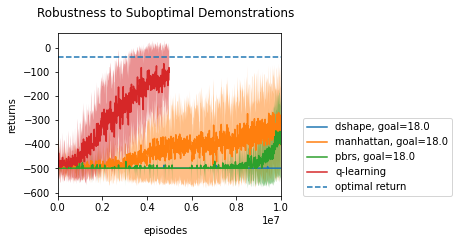

In [48]:
plot_subopt_learning_curves(expt_basenames={ # legend name: expt basename
#      "dshape, optimal demo": "dshape",
#      "dshape, goal=17": "dshape_demo-goal=17", 
#      "dshape, goal=15": "dshape_demo-goal=15", 
#      "dshape, goal=13": "dshape_demo-goal=13", 
#      "dshape, goal=11": "dshape_demo-goal=11", 
#      "dshape, goal=9": "dshape_demo-goal=9", 
#      "dshape, goal=7": "dshape_demo-goal=7", 
#      "dshape, goal=5": "dshape_demo-goal=5", 
#      "dshape, goal=3": "dshape_demo-goal=3", 
#      "dshape, goal=-15.0": "dshape_demo-goal=-15.0", 
#      "dshape, goal=-18.0": "dshape_demo-goal=-18.0", 
#      "dshape, goal=15.0": "dshape_demo-goal=15.0", 
     "dshape, goal=18.0": "dshape_demo-goal=18.0", 
#      "dshape, goal=15.0, termphi False": "dshape_demo-goal=15.0_termphi0=False", 
#      "dshape, goal=18.0, termphi False": "dshape_demo-goal=18.0_termphi0=False", 
    
#      "manhattan, optimal demo": "manhattan",
#      "manhattan, goal=17": "manhattan_demo-goal=17", 
#      "manhattan, goal=15": "manhattan_demo-goal=15", 
#      "manhattan, goal=13": "manhattan_demo-goal=13", 
#      "manhattan, goal=11": "manhattan_demo-goal=11", 
#      "manhattan, goal=9": "manhattan_demo-goal=9", 
#      "manhattan, goal=7": "manhattan_demo-goal=7", 
#      "manhattan, goal=5": "manhattan_demo-goal=5", 
#      "manhattan, goal=3": "manhattan_demo-goal=3", 
#      "manhattan, goal=-15.0": "manhattan_demo-goal=-15.0", 
#      "manhattan, goal=-18.0": "manhattan_demo-goal=-18.0", 
#      "manhattan, goal=15.0": "manhattan_demo-goal=15.0", 
     "manhattan, goal=18.0": "manhattan_demo-goal=18.0", 
#      "manhattan, goal=15.0, termphi False": "manhattan_demo-goal=15.0_termphi0=False", 
#      "manhattan, goal=18.0, termphi False": "manhattan_demo-goal=18.0_termphi0=False", 
#      "pbrs, goal=15.0": "pbrs_alone_demo-goal=15.0", 
     "pbrs, goal=18.0": "pbrs_alone_demo-goal=18.0", 
#      "pbrs, goal=15.0": "pbrs_alone_demo-goal=15.0_termphi0=False_termphi0=False", 
#      "pbrs, goal=18.0": "pbrs_alone_demo-goal=18.0_termphi0=False_termphi0=False", 
     "q-learning": "q-learning"

}, 
                     world_size=20,
                     results_dir=results_dir, 
                     world_max_ts=10e6,
                     title="Robustness to Suboptimal Demonstrations",
                     legend_loc=(1.1, 0),
                     save=False,
                     savename="suboptimal_demos",
                     savedir="../workshop_figures/"
                    )

In [ ]:
def generate_solution(style,start, goal):
    assert style in ["upper", "middle", "lower"]
    soln_path = []
    state = start
    soln_path.append(state) # (9, 0)

    if style == "middle":
        while state[0] != goal[0] and state[1] != goal[1]:
            state = (state[0] - 1, state[1])                
            soln_path.append(state)
            state = (state[0], state[1] +1)
            soln_path.append(state)
    elif style == "upper":
        while state[0] != goal[0]:
            state = (state[0] - 1, state[1])    
            soln_path.append(state)
        while state[1] != goal[1]:
            state = (state[0], state[1] + 1)    
            soln_path.append(state)
    elif style == "lower":
        while state[1] != goal[1]:
            state = (state[0], state[1] + 1)    
            soln_path.append(state)
        while state[0] != goal[0]:
            state = (state[0] - 1, state[1])    
            soln_path.append(state)        
    return soln_path

def manhattan_dist(state0, state1):
    dist = abs(state0[0] - state1[0]) + abs(state0[1] - state1[1])
    return dist

opt_path = generate_solution(style="lower", start=(19,0), goal=(0,19))

In [7]:
def measure_sample_eff(expt_name, results_dir, gridworld_size, n_trials=30, desired_value=None):
    expt_name = f"{expt_name}_world=basic_size={gridworld_size}"
    opt_ret_tss = []
    for trial_idx in range(n_trials):
        log_path = os.path.join(results_dir, expt_name, f"trial={trial_idx}", "logs.npz")
        data = np.load(log_path)
        if desired_value is None:
            desired_value = float(data['opt_rew'])
        idxs = np.where(data['env_ret'] >= desired_value)[0]
        if len(idxs)>0:
            first_idx = min(idxs) 
            opt_ret_tss.append(data['eval_ts'][first_idx]) # ts when optimal return achieved
        else: # opt rew not reached
            print(f"Warning: desired value not reached for expt {expt_name}, trial {trial_idx}. Appending last timestep.")
            opt_ret_tss.append(data['eval_ts'][-1])
    return np.mean(opt_ret_tss), np.std(opt_ret_tss)

def measure_robust_subopt(baseline_expt:str, test_expt_names:list,
                          gridworld_size, results_dir, desired_value=None):
    res_dict = {}
    baseline_sample_eff = measure_sample_eff(baseline_expt, results_dir, gridworld_size,
                                            desired_value=desired_value)[0] 
    res_dict["baseline"] = baseline_sample_eff

    for test_expt in test_expt_names:
        test_sample_eff = measure_sample_eff(test_expt, results_dir, gridworld_size, 
                                             desired_value=desired_value)[0] 
        res_dict[test_expt] = test_sample_eff - baseline_sample_eff
    return res_dict

In [ ]:
res_path = os.path.join(results_dir, "dshape_termphi0=False_demo-goal=15_world=basic_size=20", "trial=6", "logs.npz")
# res_path = os.path.join(results_dir, "dshape_demo-goal=15_world=basic_size=20", "trial=6", "logs.npz")
a = np.load(res_path)
# a['env_ret']

In [ ]:
res_path = os.path.join(results_dir, "dshape_termphi0=False_demo-goal=15_world=basic_size=20", "trial=7", "logs.npz")
a = np.load(res_path)
# a['env_ret']
# a['shaped_ret']

In [18]:
measure_robust_subopt(baseline_expt="dshape", test_expt_names=["dshape_termphi0=False_demo-goal=17",
                                                               "dshape_termphi0=False_demo-goal=15",
                                                               "dshape_termphi0=False_demo-goal=13"
                                                              ],
                     gridworld_size=20, results_dir=results_dir, desired_value=-37)

{'baseline': 887691.2,
 'dshape_termphi0=False_demo-goal=17': 204337.6000000001,
 'dshape_termphi0=False_demo-goal=15': 569337.0,
 'dshape_termphi0=False_demo-goal=13': 1377676.5666666667}

In [19]:
measure_robust_subopt(baseline_expt="dshape", test_expt_names=["dshape_demo-goal=17",
                                                               "dshape_demo-goal=15",
                                                               "dshape_demo-goal=13"
                                                              ],
                     gridworld_size=20, results_dir=results_dir, desired_value=-37)

{'baseline': 887691.2,
 'dshape_demo-goal=17': 146337.33333333337,
 'dshape_demo-goal=15': 1139670.0333333334,
 'dshape_demo-goal=13': 2907336.533333333}

In [252]:
measure_robust_subopt(baseline_expt="manhattan", test_expt_names=["manhattan_demo-goal=17",
                                                                  "manhattan_demo-goal=15",
                                                                  "manhattan_demo-goal=13"
                                                              ],
                     gridworld_size=20, results_dir=results_dir, desired_value=-37)

{'baseline': 1332822.5,
 'manhattan_demo-goal=17': 61318.43333333335,
 'manhattan_demo-goal=15': 495689.16666666674,
 'manhattan_demo-goal=13': 1114660.2999999998}

### Transfer Learning Experiment

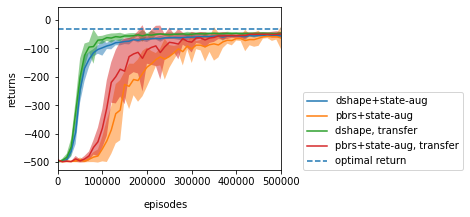

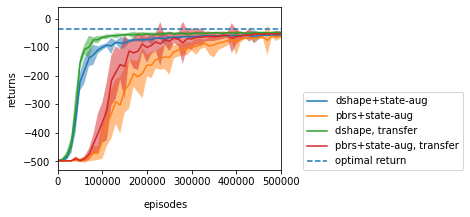

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/cluster/clw4542/gridworld_results2/dshape_demo-goal=19_grid-goal=19_world=basic_size=20/trial=0/logs.npz'

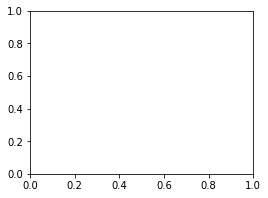

In [166]:
for goal_loc in [15, 17, 
#                  19
                ]:
    plot_subopt_learning_curves(expt_basenames={
         "dshape+state-aug": f"dshape_demo-goal={goal_loc}_grid-goal={goal_loc}",
         "pbrs+state-aug": f"pbrs+state-aug_demo-goal={goal_loc}_grid-goal={goal_loc}", 
         "dshape, transfer": f"dshape_demo-goal={goal_loc}_grid-goal={goal_loc}_transfer-learn",
         "pbrs+state-aug, transfer": f"pbrs+state-aug_demo-goal={goal_loc}_grid-goal={goal_loc}_transfer-learn", 

    }, 
                         world_size=20,
                         results_dir=results_dir, 
#                          eval_freq=eval_freq,
                         world_max_ts=5e5,
                         legend_loc=(1.1, 0),
                        )

### Plot  State Visitation

In [32]:
import matplotlib 
from poc.run_agent import get_state_aug_value


def generate_state_visitations(agents:dict, env):
    '''generate state visitation of trained agents'''
    masked_visitations_dict = {}
    for eval_label, agents_list in agents.items(): # iter over experiments
        states_all = []
        
        for agent in agents_list: # iter over trials
            env.reset()
            for _ in range(20):  # run 20 episodes test
                _, _, _, states = agent.run_episode(test_mode=True)
                states_all += states
        state_visitation = env.unwrapped.traj_on_map(states_all)
        # mask values that have not been changed from 0
        masked_visitation = np.ma.masked_where(
            state_visitation == 0., state_visitation)
        masked_visitations_dict[eval_label] = masked_visitation
    return masked_visitations_dict

def plot_state_visitation(masked_visitations_dict:dict,
                          env_params:dict,
                          title=None,
                          show_ts=False,
                          mark_nonvisited=True,
                          save=False,
                          savedir="../figures/",
                          savename=None):
    num_plots = len(masked_visitations_dict)
    subfig_width = 3
    fig, ax = plt.subplots(1, num_plots, figsize=(subfig_width*num_plots, subfig_width))
    
    # plot masked state visitations
    for i, (eval_label, masked_visitation) in enumerate(masked_visitations_dict.items()):
        if num_plots > 1: 
            ax = ax[i]
        
        cmap = copy.copy(matplotlib.cm.get_cmap('Blues'))
        if mark_nonvisited: 
            cmap.set_bad(color='mistyrose')
        
        im = ax.imshow(masked_visitation, 
                     cmap=cmap, 
                     vmin=0, 
                     vmax=0.04, # 1, 
                     interpolation='none')
        # control tick spacing
        ax.set_xticks(np.arange(0, masked_visitation.shape[0], 5))
        ax.set_yticks(np.arange(0, masked_visitation.shape[1], 5))
        
        # set title
        ts = eval_label*env_params['eval_interval'] if type(eval_label) is int else env_params['total_train_ts']
        if show_ts:
            ax.set_title(f"ts={ts}")
    
    # add color bar
    cax = fig.add_axes([1.0, # xpos
                        0.13, # ypos
                        0.035, # width
                        0.75 # height
                       ])
    plt.colorbar(im, ax=ax, cax=cax)

    fig.subplots_adjust(wspace=0.15, hspace=0)
    if title is not None:
        fig.suptitle(title)
    fig.tight_layout()
        
    if save:
        if not os.path.exists(savedir):
            os.mkdir(savedir)            
        savepath = os.path.join(savedir, savename + ".pdf")
        print(f"Saving to {savepath}")
        plt.savefig(savepath, bbox_inches="tight")

    plt.show()


In [3]:
from poc.run_agent import make_env
from poc.agent import Q_Agent

agents_base_path = "/scratch/cluster/clw4542/gridworld_results2"
env_params = {
    "gridworld_size": 20,
    "max_steps_per_episode": 500,
    "eval_interval": 10000,
    "total_train_ts": 250000
             }

In [8]:
# computing the state visitations
masked_visitations_all = {}
for agent_type, agent_params in {
    "dshape": {"expt_name": "dshape_demo-goal=19_grid-goal=19",
               "time_feat": True, "state_aug": True}, 
    "dshape-gr": {"expt_name": "pbrs+state-aug_demo-goal=19_grid-goal=19",
                  "time_feat": True, "state_aug": True}, 
}.items():
    
    env, opt_rew = make_env(gridworld_size=env_params["gridworld_size"], 
                            gridworld_goal=(0, 19),
                            reward_base_value=-1,
                            reward_type="pbrs_demo", 
                            demo_style="lower", 
                            demo_extend_type="extend_last", 
                            demo_extend_num=None,
                            demo_goal=(0, 19),
                            negate_potential=False, 
                            state_aug=agent_params["state_aug"], 
                            time_feat=agent_params["time_feat"],
                            max_steps_per_episode=env_params["max_steps_per_episode"])
    agents = {}
    for eval_label in [ # 3, 7, 20, 
                       "last"
                      ]:
        agents[eval_label] = []
        # load in some trials to generate figure
        for agent_idx in range(1, 15):
            agent = Q_Agent(env, 
                            # epsilon=0.2, alpha=0.1,
                            # init_value=0,
                            total_train_ts=5000000, 
                            max_steps_per_episode=env_params["max_steps_per_episode"], 
                            eval_interval=env_params["eval_interval"],
                            reward_modified=True,
                            # use_buffer=True, buffer_size=buffer_size,
                            # relabel=True,  
                            # n_sampled_goal=3, # can only be true if state_aug and potential_shaping is also true
                            # updates_per_step=20, 
                            # show_progress=True,
                            save_policy=False,
                            eval_only=True
                            )
            agent.load_agent(load_path=f"{agents_base_path}/{agent_params['expt_name']}_world=basic_size={env_params['gridworld_size']}/trial={agent_idx}/q-table_eval={eval_label}.npz")
            agents[eval_label].append(agent)
            
    masked_visitations_all[agent_type] = generate_state_visitations(agents, env)
    del agents

%store masked_visitations_all

Stored 'masked_visitations_all' (dict)


/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Saving to ../workshop_figures/state_agent=dshape.pdf.pdf


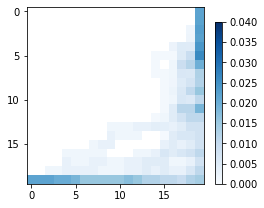

/scratch/cluster/clw4542/rlzoo/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


Saving to ../workshop_figures/state_agent=dshape-gr.pdf.pdf


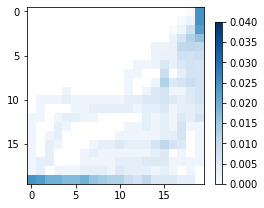

In [34]:
# plotting state visitations only
# TODO: figure out why goal state is not being counted in state visitation!
%store -r masked_visitations_all

for agent_type, masked_visitations in masked_visitations_all.items():
    # only plot last ts
    masked_visitations = {"last": masked_visitations["last"]}
    plot_state_visitation(masked_visitations, # _all[agent_type],
                          env_params=env_params,
                          show_ts=False,
                          mark_nonvisited=False,
                          save=True,
                          savedir="../workshop_figures/",
                          savename=f"state_agent={agent_type}.pdf"
                          )


### Plot Task+Demonstration

Saving to ../workshop_figures/gridworld-demo_fig.pdf


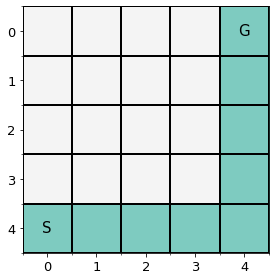

In [10]:
def plot_gridworld(gridworld_size:int, 
                   save=False, savedir="../workshop_figures/",
                   savename=""):
    plt.figure()
    data = np.ones((gridworld_size, gridworld_size)) * 0.5 # number for white
    data[gridworld_size -1 , :] = 0.7
    data[:, gridworld_size - 1] = 0.7

    im = plt.imshow(data,
                    interpolation='none', 
                    cmap='BrBG',
                    vmin=0, vmax=1, 
    #                 aspect='equal'
                   )

    ax = plt.gca();

    # Major ticks
    ax.set_xticks(np.arange(0, gridworld_size, 1))
    ax.set_yticks(np.arange(0, gridworld_size, 1))

    # Labels for major ticks
    ax.set_xticklabels(np.arange(0, gridworld_size, 1), fontsize=13)
    ax.set_yticklabels(np.arange(0, gridworld_size, 1), fontsize=13)

    # # Minor ticks
    ax.set_xticks(np.arange(-.5, gridworld_size, 1), minor=True)
    ax.set_yticks(np.arange(-.5, gridworld_size, 1), minor=True)

    # invert y-axis
    # ax.invert_yaxis()

    # add label of start and goal
    start_text = ax.text(0, gridworld_size - 1, "S", 
                         fontsize=15, 
                         ha="center", va="center", 
                         color="black"
                        )
    goal_text = ax.text(gridworld_size - 1, 0, "G", 
                        fontsize=15,
                        ha="center", va="center", 
                        color="black"
                       )

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    # plt.colorbar()
    plt.tight_layout()

    if save:
        if not os.path.exists(savedir):
            os.mkdir(savedir)            
        savepath = os.path.join(savedir, savename + ".pdf")
        print(f"Saving to {savepath}")
        plt.savefig(savepath, bbox_inches="tight")


    plt.show()
    
plot_gridworld(gridworld_size=5, 
               save=True, 
               savedir="../workshop_figures/",
               savename="gridworld-demo_fig")

In [14]:
a = np.zeros((2, 2))
np.sum(a)

0.0